# Znamení slunce aneb observační studie a selection bias

https://smis-lab.cz/2023/02/12/znameni-slunce-aneb-observacni-studie-a-selection-bias/

> Tomáš Fürst
> 
> Představme si populaci jednoho milionu lidí, kterou budeme sledovat po sto po sobě jdoucích dní. Náhodně vybereme setinu populace, která během sledované doby zemře. Čas úmrtí každého nešťastníka je vybrán náhodně s rovnoměrným rozdělením přes sto sledovaných dnů. Dále náhodně vybereme asi třetinu populace, která si někdy během roku dojde na Hlavní nádraží pro Znamení slunce (to je malý obrázek sluníčka, který je zájemcům nakreslen henou na rameno). Čas udělení Znamení slunce je také náhodně vybrán s rovnoměrným rozdělením přes sto sledovaných dnů. Občas se stane, že čas Znamení bude vylosován až po úmrtí daného člověka – takové znamení prostě ignorujeme.
> 
> Máme tedy milion lidí, z nichž asi 10 tisíc postupně zemře a asi 330 tisíc postupně obdrží Znamení slunce. Znamení slunce a úmrtí jsou dle výše uvedeného modelu zcela nezávislé, účinnost Znamení slunce proti úmrtí je přesně nulová. Pro každý den spočteme úmrtnost sluníčkových (tedy procento lidí se Znamením, kteří daný den zemřeli) a úmrtnost nesluníčkových (procento lidí bez Znamení, kteří daný den zemřeli). Není nijak překvapivé, že obě úmrtnosti budou přibližně konstantní, obě budou přibližně stejně velké a rovné přibližně 10-4. Graf ze sta opakování výše popsaného modelu je níže. Je zobrazen sedmidenní centrální klouzavý průměr denní úmrtnosti, abychom mírně potlačili šum.

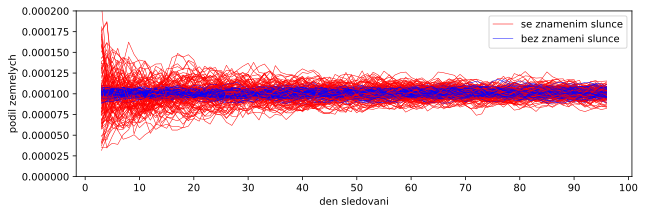

In [104]:
experiment = Experiment(
    popsize=1_000_000, days=100, q_kill=0.01, q_sign=0.33,
    rng=np.random.default_rng(42)
)
experiment.run_iterated_parallel(100)
experiment.plot_mortality(window_days=7)

> Velký počáteční rozptyl úmrtnosti sluníčkových (červeně) je dán efektem malých čísel – na začátku sledovaného období je lidí se Znamením slunce v populaci ještě velmi málo. Rozptyl úmrtnosti nesluníčkových (modře) naopak velmi zvolna v čase roste, neboť neoznačených v čase ubývá.
> 
> Nyní proveďme v modelu drobnou změnu. Každé Znamení slunce, které bylo uděleno méně než 14 dnů před úmrtím, s pravděpodobností p=0.5 zrušme. Tato drobná změna má zachytit fakt, že kdo je na umření, pravděpodobně si nepůjde nechat na Hlavní nádraží kreslit Znamení slunce na rameno. Je třeba upozornit, že z přibližně 330 tisíc udělených Znamení slunce tímto způsobem vyřadíme jen asi šest set, což je zcela zanedbatelné množství. Nyní tedy modelujeme situaci, kdy Znamení slunce s pravděpodobností úmrtí samozřejmě opět nijak nesouvisí (skutečná účinnost je tedy nulová), ovšem dochází k mírnému „selection bias“ v tom smyslu, že lidé, kteří jsou na umření, chodí pro Znamení méně často. Jak bude vypadat výsledek sta běhů tohoto upraveného modelu?

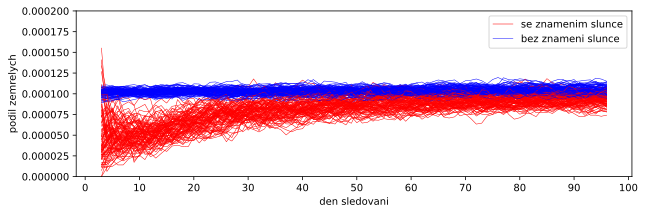

In [103]:
experiment = Experiment(
    popsize=1_000_000, days=100, q_kill=0.01, q_sign=0.33,
    prevent_sign_before_death_days=14, prevent_sign_before_death_p=0.5,
    rng=np.random.default_rng(42)
)
experiment.run_iterated_parallel(100)
experiment.plot_mortality(window_days=7)

> Efekt je překvapivý a dramatický: Znamení slunce má najednou zdánlivě kladnou účinnost proti úmrtí! Tato zdánlivá účinnost z počátečních velmi optimistických hodnot (kolem padesáti procent) postupně v čase klesá až téměř k nule na konci sledovaného období.
> 
> Jednoduchou úpravou parametru p jsme schopni dosáhnout jakkoliv vysoké počáteční zdánlivé účinnosti. Znovu připomínám, že oba modely pracují se Znamením slunce, která má nulovou skutečnou účinnost, a druhý model se od prvního liší pouze neudělením asi 0.2% znamení, která v prvním modelu udělena byla.
> 
> Už chápete?

&nbsp;

---

&nbsp;

In [ ]:
!pip install numpy==1.26.3 polars==0.19.19 matplotlib==3.8.2

In [95]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats
import concurrent.futures
import datetime
set_matplotlib_formats('pdf', 'svg')

In [101]:
class Experiment:
    def __init__(self, popsize: int, days: int, q_kill: float, q_sign: float,
                 prevent_sign_before_death_days: int | None = None,
                 prevent_sign_before_death_p: float = 0.5,
                 rng: np.random.Generator | None = None) -> None:
        self.popsize = popsize
        self.days = days
        self.q_kill = q_kill
        self.q_sign = q_sign
        self.prevent_sign_before_death_days = prevent_sign_before_death_days
        self.prevent_sign_before_death_p = prevent_sign_before_death_p

        self._rng = rng or np.random.default_rng()

        self.instances: list["ExperimentInstance"] = []

    def run(self) -> None:
        instance = self._run()
        self.instances.append(instance)

    def _run(self, rng: np.random.Generator | None = None) -> "ExperimentInstance":
        if rng is None:
            rng, = self._rng.spawn(1)
        instance = ExperimentInstance(self, rng)
        instance.run()
        return instance

    def run_iterated(self, n: int) -> None:
        rngs = self._rng.spawn(n)
        
        for rng in rngs:
            instance = self._run(rng)
            self.instances.append(instance)

    def run_iterated_parallel(self, n: int) -> None:
        rngs = self._rng.spawn(n)
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            instances = executor.map(self._run, rngs)
        
        self.instances.extend(instances)

    def plot_mortality(self, window_days: int) -> None:
        fig, ax = plt.subplots()
        
        for instance in self.instances:
            df = instance.result_df
            day = df["day"]
            signed = df["signed_mortality_today"].rolling_mean(window_days, center=True)
            unsigned = df["unsigned_mortality_today"].rolling_mean(window_days, center=True)
            
            line1, = ax.plot(day, signed, color="red", linewidth=0.5,
                             label="se znamenim slunce")
            line2, = ax.plot(day, unsigned, color="blue", linewidth=0.5,
                             label="bez znameni slunce")
        
        ax.legend(handles=[line1, line2])
        ax.set_xlabel("den sledovani")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.set_ylabel("podil zemrelych")
        ax.set_ylim(0, 2e-4)
        fig.set_size_inches(10, 3)


class ExperimentInstance:
    def __init__(self, experiment: Experiment, rng: np.random.Generator) -> None:
        self.experiment = experiment
        self._rng = rng
        self.result_df: pl.DataFrame | None = None

    def run(self) -> None:
        population_df = self.make_population_df()
        self.result_df = self.iterate_days(population_df)
    
    def make_population_df(self) -> pl.DataFrame:
        n_kill = int(self.experiment.popsize * self.experiment.q_kill)
        n_sign = int(self.experiment.popsize * self.experiment.q_sign)
        
        person_id = np.arange(self.experiment.popsize, dtype=np.int32)
        person_id_kill = self._rng.choice(person_id, size=n_kill, replace=False, shuffle=True)
        person_id_sign = self._rng.choice(person_id, size=n_sign, replace=False, shuffle=True)
        stubborn = self._rng.binomial(1, self.experiment.prevent_sign_before_death_p, size=n_sign).astype(np.bool_)
        day_kill = self._rng.integers(self.experiment.days, size=n_kill, dtype=np.int32)
        day_sign = self._rng.integers(self.experiment.days, size=n_sign, dtype=np.int32)
        
        day_df = pl.DataFrame({"day": np.arange(self.experiment.days, dtype=np.int32)})
        person_df = pl.DataFrame({"person_id": person_id})
        kill_df = pl.DataFrame({"person_id": person_id_kill, "day_kill": day_kill})
        sign_df = pl.DataFrame({"person_id": person_id_sign, "day_sign": day_sign, "stubborn": stubborn})

        ignore_sign_expr = (pl.col("day_kill") < pl.col("day_sign"))
        if self.experiment.prevent_sign_before_death_days is not None:
            ignore_sign_expr |= (
                (pl.col("day_kill") - pl.col("day_sign") < self.experiment.prevent_sign_before_death_days)
                & ~pl.col("stubborn")
            )
        
        population_df = (
            person_df
            .join(sign_df, on="person_id", how="left")
            .join(kill_df, on="person_id", how="left")
            .with_columns(
                # re-evaluate day_sign based on context
                day_sign=pl.when(ignore_sign_expr).then(None).otherwise(pl.col("day_sign"))
            )
        )

        return population_df

    def iterate_days(self, population_df: pl.DataFrame) -> pl.DataFrame:
        population_df = population_df.with_columns(
            dead=False,
            signed=False,
        )

        results_per_day = []

        for day in range(self.experiment.days):
            kill_today = (population_df["day_kill"] == day).fill_null(False)
            sign_today = (population_df["day_sign"] == day).fill_null(False)
            signed_after = sign_today | population_df["signed"]
            dead_after = kill_today | population_df["dead"]
            
            died_today_signed = (kill_today & signed_after).sum()
            died_today_unsigned = (kill_today & ~signed_after).sum()
            alive_signed_after_giving_sign = (~dead_after & signed_after).sum()
            alive_unsigned_after_giving_sign = (~dead_after & ~signed_after).sum()
        
            population_df = population_df.with_columns(
                signed=signed_after,
                dead=dead_after,
            )
        
            # report stats at end of day
            results_per_day.append({
                "day": day,
                "signed_mortality_today": died_today_signed / max(1, alive_signed_after_giving_sign),
                "unsigned_mortality_today": died_today_unsigned / max(1, alive_unsigned_after_giving_sign),
            })

        result_df = pl.from_dicts(results_per_day)
        return result_df

In [106]:
%%timeit

experiment = Experiment(
    popsize=1_000_000, days=100, q_kill=0.01, q_sign=0.33,
    prevent_sign_before_death_days=14, prevent_sign_before_death_p=0.5,
    rng=np.random.default_rng(42)
)
experiment.run_iterated_parallel(100)

14.7 s ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%%timeit -r 1 -n 1

experiment = Experiment(
    popsize=1_000_000, days=100, q_kill=0.01, q_sign=0.33,
    prevent_sign_before_death_days=14, prevent_sign_before_death_p=0.5,
    rng=np.random.default_rng(42)
)
experiment.run_iterated(100)

2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
